## pytorch_seresnext101-32x4d+kfold+focal loss v3.0


* fold = 4
* epoch = 3
* γ=0.4

In [1]:
!nvidia-smi

Thu Jun  6 05:42:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import math
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
from datetime import datetime
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import random
import datetime
import os

from sklearn import preprocessing 
from sklearn.model_selection import KFold

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# os.chdir("../input/pretrained_PyTorch/")
# os.getcwd()

In [4]:
train = pd.read_csv("../input/imet-2019-fgvc6/train.csv")
lable = pd.read_csv("../input/imet-2019-fgvc6/labels.csv")
test = pd.read_csv("../input/imet-2019-fgvc6/sample_submission.csv")

In [5]:
lable_length = len(lable)
train_length = len(train)
test_length = len(test)
print(train_length)
print(lable_length)
print(test_length)

109237
1103
7443


In [6]:
print(np.array(lable)[397])
print(np.array(lable)[398])
c_length = len(np.array(lable)[:398])
t_length = len(np.array(lable)[398:])
print(c_length)
print(t_length)

[397 'culture::zurich']
[398 'tag::abbies']
398
705


In [7]:
#np.array(test)

In [8]:
test.head

<bound method NDFrame.head of                     id attribute_ids
0     10023b2cc4ed5f68         0 1 2
1     100fbe75ed8fd887         0 1 2
2     101b627524a04f19         0 1 2
3     10234480c41284c6         0 1 2
4     1023b0e2636dcea8         0 1 2
5      1039cd6cf85845c         0 1 2
6      103a5b3f83fbe88         0 1 2
7     10413aaae8d6a9a2         0 1 2
8     10423822b93a65ab         0 1 2
9     1052bf702cb099f7         0 1 2
10     10543c918a43a8d         0 1 2
11    105c9a3453da79c3         0 1 2
12    1060688bbf6eac87         0 1 2
13    106a247caeabd15a         0 1 2
14    106e21606add59f3         0 1 2
15    107c38495881b6c9         0 1 2
16    108815dd3752ab64         0 1 2
17    10943defdd5d5e89         0 1 2
18    10a39a78c44ef27c         0 1 2
19     10ab70df067bdb4         0 1 2
20    10b28e3de3566582         0 1 2
21    10b32964331a6cc3         0 1 2
22    10b4562e7fa6f668         0 1 2
23    10db1c338e1d822f         0 1 2
24    10e0c215f5f3084e         0 1 2
25    10

In [9]:
#np.array(train)

In [10]:
def creatData(train,lable_length):
    train = np.array(train)
    trainA_data = []
    lab_data = []
    #trainC_data = []
    #trainT_data = []
    for t in range(train_length):
        v = np.zeros(lable_length)
        #print(train[t,1])
        lab = []
        for s in train[t,1].split(" "):
            #print(s)
            v[int(s)] = 1
            lab.append(int(s))
        trainA_data.append([train[t,0],v])
        lab_data.append([train[t,0],np.array(lab)])
        #trainC_data.append([train[t,0],v[:c_length]])
        #trainT_data.append([train[t,0],v[c_length:]])
    return np.array(trainA_data),np.array(lab_data)
    #return np.array(trainA_data)#,np.array(trainC_data),np.array(trainT_data)

In [11]:
train_a,train_lab = creatData(train,lable_length)
#train_a,train_c,train_t = creatData(train,lable_length)
#train_t.shape()

In [12]:
train_lab[0]

array(['1000483014d91860', array([147, 616, 813])], dtype=object)

### Remove the item that only have one feature (not work well)

In [13]:
def dfilter(data,th):
    dfilter = []
    for i in range(len(data)):
        if train_a[i][1].sum()>th:
            dfilter.append(train_a[i])
    return np.array(dfilter)

In [14]:
datafilter = dfilter(train_a,1) # remain feature great then 1

In [15]:
print(f"amount of image before: {len(train_a)}")

print(f"amount of image after: {len(datafilter)}")

amount of image before: 109237
amount of image after: 104913


In [16]:
# not use
datafilter = train_a

In [17]:
image_resize = 200
data_transforms2 = transforms.Compose([
    transforms.Resize((image_resize,image_resize)),
    #transforms.RandomResizedCrop(250),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
            [0.485, 0.456, 0.406], 
            [0.229, 0.224, 0.225])
    ])


data_transforms = transforms.Compose([
    transforms.Resize((image_resize,image_resize)),
    #transforms.RandomResizedCrop(250),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(
    #        [0.485, 0.456, 0.406], 
    #        [0.229, 0.224, 0.225])
    ])

train_transformer = transforms.Compose([
    transforms.Resize((128,128)),              # resize the image to 
    #transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.ToTensor(),           # transform it into a PyTorch Tensor
    #transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [18]:
class trainDataset(Dataset):
    def __init__(self, train_lib, transform,transform2):
        self.filenames = train_lib[:,0]
        self.labels = train_lib[:,1]
        self.transform = transform
        self.transform2 = transform2
        #self.new_feature = 

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open("../input/imet-2019-fgvc6/train/"+format(self.filenames[idx])+'.png')  # PIL image
        #image= image.filter(ImageFilter.EDGE_ENHANCE)
        #image2 = image.filter(ImageFilter.FIND_EDGES)
        image = self.transform(img)
        image2 = self.transform2(img)
        #return image, self.labels[idx]
        return image,image2, self.labels[idx]


In [19]:
class testDataset(Dataset):
    def __init__(self, test_lib, transform,transform2):
        test_lib = np.array(test_lib)
        self.filenames = test_lib[:,0]
        #self.labels = test_lib[:,1]
        self.transform = transform
        self.transform2 = transform2

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open("../input/imet-2019-fgvc6/test/"+format(self.filenames[idx])+'.png')  # PIL image
        #image= image.filter(ImageFilter.EDGE_ENHANCE)
        #image2 = image.filter(ImageFilter.FIND_EDGES)
        image = self.transform(img)
        image2 = self.transform2(img)
        #return image,self.filenames[idx]
        return image,image2,self.filenames[idx]

In [20]:
trainA_dataloader = DataLoader(trainDataset(datafilter, data_transforms,data_transforms2),batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
#trainC_dataloader = DataLoader(trainDataset(train_c, data_transforms,data_transforms2),batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
#trainT_dataloader = DataLoader(trainDataset(train_t, data_transforms,data_transforms2),batch_size=32, shuffle=True,num_workers=2, pin_memory=True)

In [21]:
score_dataloader = DataLoader(trainDataset(datafilter[:1000], data_transforms,data_transforms2),batch_size=32, shuffle=False,num_workers=2, pin_memory=True)

In [22]:
test_dataloader = DataLoader(testDataset(test, data_transforms,data_transforms2),batch_size=32,shuffle=False,num_workers=2, pin_memory=True)

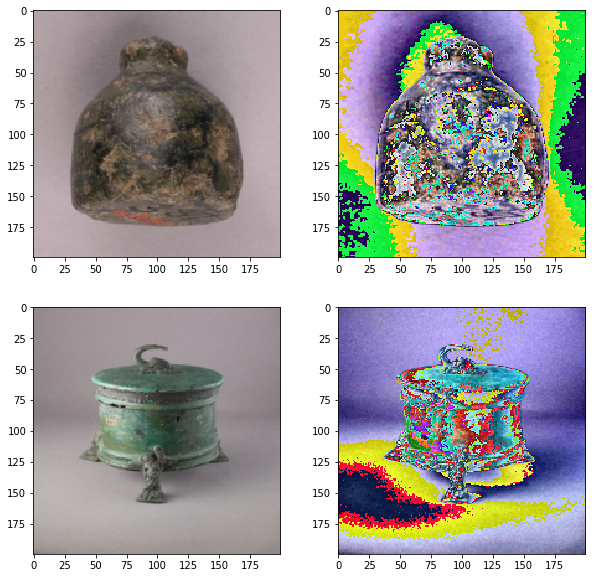

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[15][0]).convert('RGB'))
plt.subplot(2,2,2)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[15][1]).convert('RGB'))
plt.subplot(2,2,3)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[29][0]).convert('RGB'))
plt.subplot(2,2,4)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[29][1]).convert('RGB'))


In [24]:
#(np.array(trainC_dataloader.dataset[4][0]).shape)

In [25]:
# https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py
"""
ResNet code gently borrowed from
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [26]:
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove

cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models/')
if not exists(models_dir):
    makedirs(models_dir)
    
copyfile("../input/pretrained-pytorch/densenet201-c1103571.pth", models_dir+"densenet201-c1103571.pth")
copyfile("../input/pretrained-pytorch/resnet50-19c8e357.pth", models_dir+"resnet50-19c8e357.pth")
copyfile("../input/pretrained-se-resnet/se_resnext101_32x4d-3b2fe3d8.pth", models_dir+"se_resnext101_32x4d-3b2fe3d8.pth")

'/tmp/.torch/models/se_resnext101_32x4d-3b2fe3d8.pth'

In [27]:
!ls ~/.torch/models 

densenet201-c1103571.pth  se_resnext101_32x4d-3b2fe3d8.pth
resnet50-19c8e357.pth


In [28]:
class Ensemble(nn.Module):
    def __init__(self, modelA, modelB,input_length,output_length):
        super(Ensemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(input_length, output_length)
        
    def forward(self, xin,xin2):
        x1 = self.modelA(xin)
        x2 = self.modelB(xin2)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x

    
# efficientNet = EfficientNet.from_name('efficientnet-b7') 
# efficientNet._fc = nn.Linear(in_features=1280, out_features=lable_length)


seresnext_model = se_resnext101_32x4d(pretrained='imagenet')
seresnext_model.last_linear = nn.Linear(in_features=2048, out_features=lable_length, bias=True)

#densenet_model = models.densenet201(pretrained=True)
#densenet_model.load_state_dict(torch.load( models_dir+"densenet201-c1103571.pth"))
#densenet_model.classifier= nn.Linear(in_features=1920,out_features=lable_length)

#efficientNet = EfficientNet(width_coeff=2.0, depth_coeff=3.1,drop_connect_rate=0.5,num_classes = lable_length)

resnet_model = models.resnet50(pretrained=True)
#resnet_model.load_state_dict(torch.load("../models/resnet50.pth"))
resnet_model.fc= nn.Linear(in_features=2048, out_features=lable_length)

#model = Ensemble(seresnext_model, resnet_model,lable_length*2,lable_length)
#model.to(device)

model = seresnext_model
model.to(device)

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_po

In [29]:
def train(epoch,fnum,dloader):
    model.train()
    for step, (x,x2,y) in enumerate(dloader):
        data = Variable(x).cuda()   # batch x
        #data2 = Variable(x2).cuda()
        target = Variable(y).cuda()   # batch y
        #print(data.size())
        #print(data2.size())
        #print(target.size())
        #output = model(data,data2)
        output = model(data)

        loss = loss_func(output, target.float())   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        if step==0:
            start = time.time()
            #break
            ti = 0
        elif step==100:
            ti = time.time()-start #total time = ti*(length/100)
            #print(ti)
            ti = ti*(len(dloader)/100)
        if step % 100 == 0:
            second = ti*(((len(dloader)-step)/len(dloader)))#*(5-epoch)*(4-fnum)
            print('Train Fold:{}/4  Ep: {}/3 [{}/{} ({:.0f}%)]\t Loss: {:.6f}\t Remain : {} '.
                     format(fnum+1,
                            epoch+1, 
                            step * len(data), 
                            len(dloader.dataset),
                            100.*step/len(dloader), 
                            loss.data.item(),
                            datetime.timedelta(seconds = int(second))))
        data.cpu()
        #data2.cpu()
        target.cpu()
        torch.cuda.empty_cache()
    print("Finish")

In [30]:
def val(dloader):
    model.eval()
    los = []
    for step, (x,x2, y) in enumerate(dloader):
        data = Variable(x).cuda()
        #data2 = Variable(x2).cuda()
        target = Variable(y).cuda()
        
        #output = model(data,data2)
        output = model(data)
        
        loss = loss_func(output, target.float())
        los.append(loss.item())
        
        
        if step %100 == 0:
            print('[{}/{} ({:.1f}%)]'.format(step * len(data), 
                                        len(dloader.dataset),
                                        100.*step/len(dloader)))
        data.cpu()
        #data2.cpu()
        target.cpu()
        torch.cuda.empty_cache()
    los = np.array(los)
    avg_val_loss = los.sum()/len(los)
    print(f"Avg val loss: {avg_val_loss:.8f}")
    #return ans,out
    

In [31]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [ ]:
fold = KFold(n_splits = 4, random_state = 10)
for fold_num, (trn_idx, val_idx) in enumerate(fold.split(datafilter)):
    Ftrain_dataloader = datafilter[trn_idx, :]
    Fval_dataloader = datafilter[val_idx, :]

    val_dataloader = DataLoader(trainDataset(Fval_dataloader, data_transforms,data_transforms2),batch_size=32, shuffle=False,num_workers=2, pin_memory=True)
    train_dataloader = DataLoader(trainDataset(Ftrain_dataloader, data_transforms,data_transforms2),batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
    for epoch in range(3):
        ###########################################
        if epoch==0:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.0001/(2**epoch))
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=0.0001,momentum=0.9, weight_decay=1e-4)
        #optimizer = torch.optim.Adam(model.parameters(), lr=0.00002/(2**epoch))
        #optimizer = torch.optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
        loss_func = FocalLoss(0.4)
        #loss_func = torch.nn.MSELoss()
        ###########################################
        train(epoch,fold_num,train_dataloader) 
        val(val_dataloader)

Train Fold:1/4  Ep: 1/3 [0/81927 (0%)]	 Loss: 0.536362	 Remain : 0:00:00 


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
torch.save(model, 'net.pkl')
#model = torch.load('net.pkl')

In [ ]:
def findPre(output,gate):
    a = ''
    output = np.array(output)
    m = np.max(output)

    for i in range(len(output)):
        #s = np.where(v[i] > 0.95, 1, 0)
        if output[i]>gate:
            #print(output[i])
            a = a + format(i)+' '
            
    #print(a)
    return a
    

In [ ]:
def test(model,dloader,threshold):
    model = model.eval().cuda()
    #lengthD = len(dloader.dataset)
    ans = []
    out = []
    for step, (x,x2, y) in enumerate(dloader):
        data = Variable(x).cuda()
        #data2 = Variable(x2).cuda()
        #data = Variable(x)
        target = y
        #output = model(data,data2)
        output = model(data).detach()
        
        #data.cpu()   # batch x
        #data2.cpu()   # batch x
        #target.cpu()   # batch y
        #torch.cuda.empty_cache()
        
        v = output.cpu()
        v = torch.sigmoid(v)
        
        v = torch.sigmoid(v)
        v = np.array(v)
        v = preprocessing.minmax_scale(v, feature_range=(0,1),axis=1)
        for i in range(len(v)):
            out.append(np.where(v[i] > threshold, 1, 0))
            s = findPre(v[i],threshold)
            ans.append([target[i],s])
        if step %10 == 0:
            print('[{}/{} ({:.1f}%)]'.format(step * len(data), 
                                        len(dloader.dataset),
                                        100.*step/len(dloader)))
            
        data.cpu()
        #data2.detach()
        #target.detach()
        torch.cuda.empty_cache()
    print("Finish")
    return ans,out
    

In [ ]:
from sklearn.metrics import fbeta_score

def makeScore(pre,ans):
    pre = np.array(pre)
    va = fbeta_score(y_pred=pre, y_true=ans, beta=2, average="samples")
    print("Score : {:.5f}".format(va))
    return va
    

In [ ]:
def findThreshold():
    score = []
    candidates = np.arange(0, 1.0, 0.01)
    for th in candidates:
        print("Threshold : {:.2f}".format(th))
        _,pre = test(model = model,dloader = score_dataloader,threshold = th)
        #return pre
        score.append(makeScore(np.array(pre),np.array(train_a[:1000,1].tolist())))
        print("=============================")
    pm = np.array(score).argmax()
    best_th, best_score = candidates[pm], score[pm]
    return best_th, best_score

In [ ]:
bt, bs = findThreshold()
print("Best Threshold : {:.2f}".format(bt))
print("Best Score : {:.5f}".format(bs))

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
sub,_ = test(model = model,dloader = test_dataloader,threshold = bt)

In [ ]:
sub =  pd.DataFrame(sub)

In [ ]:
sub = sub.rename(index=str, columns={0: "id", 1: "attribute_ids"})

In [ ]:
sub.head

In [ ]:
sub.to_csv('submission.csv', index=False)